This work is a replication of Intraday Trend trading strategy with S&P500 index as underlying index,
backtesting from 13 Sep 2021 to 18 Oct 2021.

Data is downloaded from Bloomberg saved in spreadsheet.

- SPX: close price and close price on previous trading day
- Intra day tick data (minutes), categorized into Observation window and Execution window
    - TWAP_i: time weighted average price within 5-minutes window

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel("IntraDayTrend.xlsx",sheet_name="Sheet3")
# df.head()
df1 = df.iloc[:,3:6]
df2 = df1.dropna()
df2 = df2.rename(columns={"O: Observation; E: Execution; NA":"Type", "Timestamp.1": "Timestamp_1", 
                         "Timestamp.2": "Timestamp_2"})
# df2
temp0= df2.Type.str.split(",", expand = True, n=1)
temp0.columns = ["Obs","NO."]
temp0 = pd.concat([df2,temp0],join="outer", axis=1)
temp1 = df2.Timestamp_1.str.split(" ",expand=True,n=1)
temp1.columns=['Date',"Time"]
temp1['Date'] = pd.to_datetime(temp1['Date'],format="%d/%m/%y")
temp1 = pd.concat([temp0,temp1],join="outer", axis=1)
temp2 = temp1.set_index(["Date","Time",'Obs'])
# temp2
twap = temp2.groupby(['Date','Obs']).mean()
twap = twap.rename(columns={"SPX": "TWAP"})
# twap
twap.to_excel("twap.xlsx")
#dates = temp2.index.get_level_values(0)
# twap.axes
twap_o = twap.loc(axis=0)[:, ["O1","O2","O3", "O4", "O5","O6"]]
twap_o = twap_o.sort_values(by=['Date','Obs'], ascending=True)
twap_o_mtrx = twap_o.reset_index().pivot(index='Date', columns='Obs',)['TWAP'] # (21,6)

twap_e = twap.loc[set(twap.index).difference(set(twap_o.index)),:]
twap_e = twap_e.sort_values(by=['Date','Obs'], ascending=True)
twap_e_mtrx = twap_e.reset_index().pivot(index='Date', columns='Obs',)['TWAP']
# twap_o_mtrx.shape

date_idx = twap_e.index.get_level_values(0) #121
dates = date_idx.unique() #21
# twap_e.loc[(dates[2],'E'+str(1)),:]

Strategy Level (daily)

In [56]:
spx_daily = pd.read_excel('SPX_Daily.xlsx',sheet_name="SPX_Daily_Data")
# spx_daily.shape
dft = pd.DataFrame(data = {"Date":spx_daily['Date'],"S_t": np.zeros((spx_daily.shape[0],))})
dft.iloc[0,1]=100
# dft
dft['S_t_1'] = dft['S_t'].shift(1)
# weekdays and reset days
dft["Weekday"] = pd.to_datetime(dft['Date']).dt.weekday
dft['Weekday'] = dft['Weekday'].apply(lambda x: x+1)
dft.loc[dft['Weekday'] == 1, 'Reset Day'] = 1
dft = dft.fillna(0)

spx_daily1 = spx_daily.merge(dft,how='left',on ="Date")
spx_daily1 = spx_daily1.rename(columns={'PX_CLOSE_1D':'UI_t_1','LAST_PRICE':'UI_t'})
# spx_daily1.shape()

spx_daily1['S_r'] = spx_daily1['S_t'][spx_daily1['Reset Day']==1].replace(0,100)
# spx_daily1['S_r']

#spx_daily1['S_r'] = spx_daily1['S_r'].fillna(method = 'ffill')
#spx_daily1['S_t_1'] = spx_daily1['S_t'].shift(1)

spx_daily1.iloc[0,3]=100
spx_daily1.iloc[0,6]=100
spx_daily1 = spx_daily1.set_index('Date')
# spx_daily1

s = spx_daily1.S_t
s_r = spx_daily1.S_r.fillna(method='ffill')
ui0 = spx_daily1.UI_t_1
ui = spx_daily1.UI_t
length = len(dates)

The dataframe is an initiative df for calculation key parameters:

- UI (underlying index - SPX, UI_t close price on T day, UI_t_1 close price on T-1 day)
- S (strategy level S0 = 100)
- Every Monday is reset day

In [57]:
spx_daily1

,UI_t_1,UI_t,S_t,S_t_1,Weekday,Reset Day,S_r
Date,,,,,,,
2021-09-13,4458.58,4468.73,100.0,0.0,1,100.0,100.0
2021-09-14,4468.73,4443.05,0.0,100.0,2,0.0,NaN
2021-09-15,4443.05,4480.70,0.0,0.0,3,0.0,NaN
2021-09-16,4480.70,4473.75,0.0,0.0,4,0.0,NaN
2021-09-17,4473.75,4432.99,0.0,0.0,5,0.0,NaN
2021-09-20,4432.99,4357.73,0.0,0.0,1,1.0,100.0
2021-09-21,4357.73,4354.19,0.0,0.0,2,0.0,NaN
2021-09-22,4354.19,4395.64,0.0,0.0,3,0.0,NaN
2021-09-23,4395.64,4448.98,0.0,0.0,4,0.0,NaN


Strategy Calculation

In [58]:
# param
# levFtr= 45
# delta_cap = 1.8
# hourly_delta_cap=0.45
# hourly_return_threshold = 0.005
# eod_trading_cost = 0.00007
# intra_delta_turnover_cost=[0.0002,0.00025,0.0003]
s=[100]
mult=[1]
# delta1 = np.empty((6,))
hourly_delta_cap=[0.01]
delta_cap=[0.04]
delta=np.empty(shape=[21,6])
pnl = np.empty(shape=[21])

'''
Formula below generates value of Strategy
'''

for t in range(1,length):
    mult.append(45*(s_r[t-1]/ui0[t]))
    delta_cap.append(-0.04*s[t-1]/s_r[t-1])
    hourly_delta_cap.append(-0.01*s[t-1]/s_r[t-1])
    for i in range(1,6):
#         print(np.add.reduce(delta[t][:i]))
        if abs(np.log(twap_o_mtrx.iloc[t,i]/ui0[t])-np.add.reduce(delta[t][:i]))>0.005:
            delta[t,i] = np.minimum(hourly_delta_cap[t],
                                    np.maximum(-hourly_delta_cap[t],
                                               np.minimum(delta_cap[t],
                                                          np.maximum(-delta_cap[t],
                                                                     np.log(twap_o_mtrx.iloc[t,i]/ui0[t]))))
                                    -np.add.reduce(delta[t][:i]))
        else:
            delta[t,i] = 0
        pnl[t] = np.sum(delta[t,i]*(ui0[t]-twap_e_mtrx.iloc[t,i]))
    s.append(100+np.dot(mult[t],pnl[t]))
    s_r[t] = s[t]

In [59]:
# len(pnl)
# delta.shape
# len(s)
strategy = pd.Series(s, index = dates, name='Strategy')
# strategy.index=dates
PnL = pd.Series(pnl,index = dates, name='PnL')
UI = pd.Series(ui,index = dates, name='UI')
#strategy.plot()
dff = pd.DataFrame(data = [strategy,PnL, ui]).T
pd.DataFrame([dff['Strategy']/dff['Strategy'].shift()-1]).T
dfff = dff/dff.shift()-1
dfff.iloc[:,[0,2]].plot(title = 'Daily Return: Strategy vs SPX', figsize = (20,5)) # plot of daily return

'''
Plot of Strategy vs SPX
'''

fig, ax = plt.subplots()
plt.plot(dff['Strategy'], '--r', label='Strategy')
plt.legend()
#ax.tick_params('vals', colors='r')

# Get second axis
ax2 = ax.twinx()
plt.plot(dff['UI_t'], '--k', label='SPX')
plt.legend()
#ax.tick_params('vals', colors='b')
fig.set_size_inches(20, 5)
ax.set_title('Value: Strategy vx SPX')
#PnL.plot()

Text(0.5, 1.0, 'Value: Strategy vx SPX')

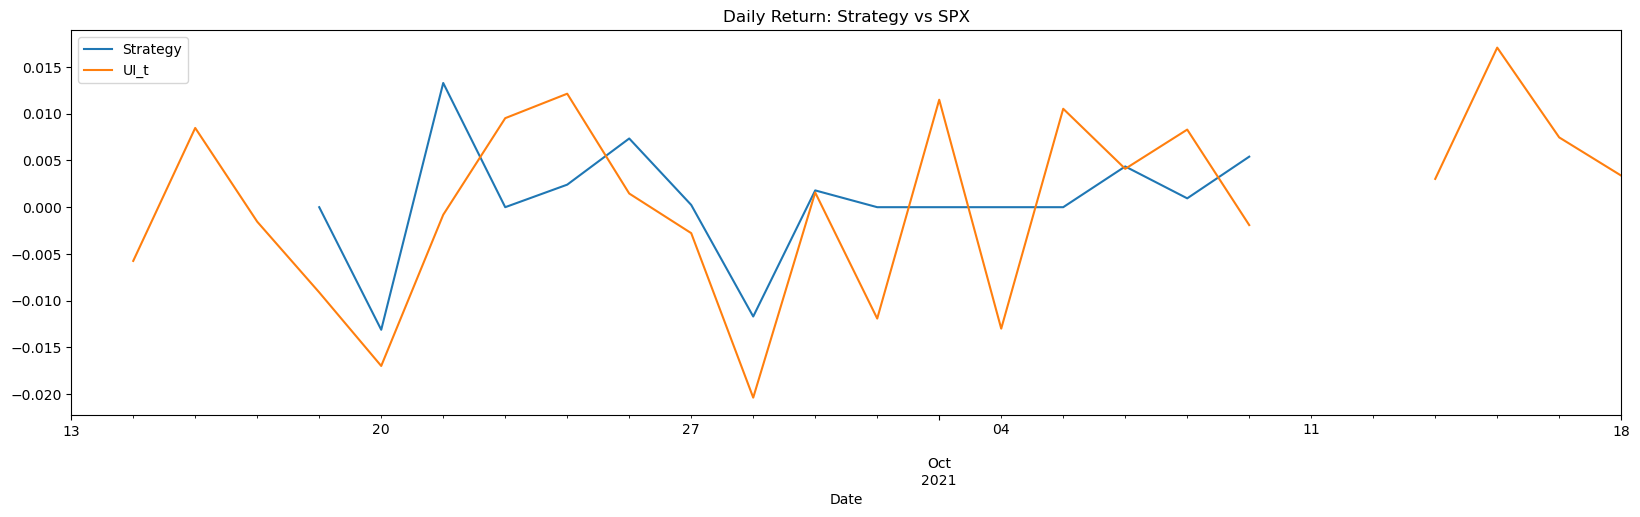

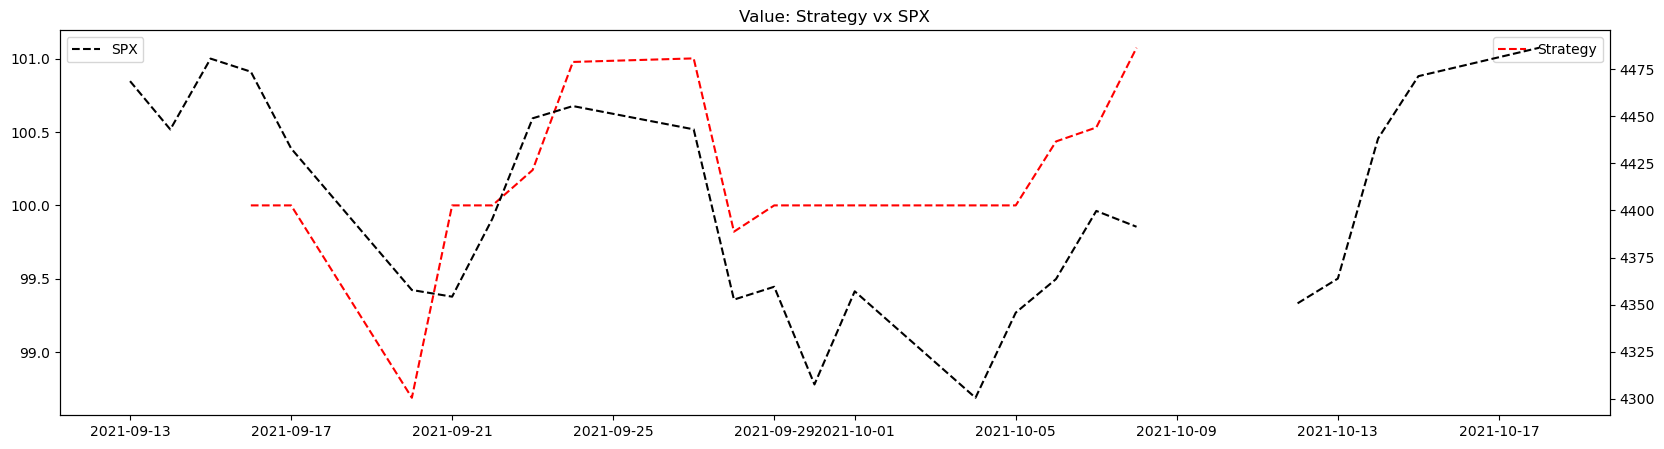

In [60]:
plt.show()
#spx_daily1.to_excel('spx_daily2.xlsx')


Reference: termsheet of a proprietary strategy
